# Stochastic SIR model analysis using pyABC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyabc

## Define model and data

In [2]:
low_beta = 0.01 
high_beta = 1. 
low_gamma = 0.

def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for rate parameters: 
    beta_samples = np.random.uniform(low=low_beta, high=high_beta, size=batch_size)
    gamma_samples = np.random.uniform(low=low_gamma, high=beta_samples)
    p_samples = np.c_[beta_samples, gamma_samples]
    return p_samples.astype(np.float32)

N = 1000   # population size
u0 = [N-1,1,0]   # initial state  
iota = 0.5 
dt = 0.1   # time step
n_dt = 500   # number of simulation time steps
t_end = n_dt * dt
n_obs = 21   # number of observations
time_points = np.linspace(0, t_end, n_obs)

def simulate_sir_single(beta, gamma):
    """Simulates a single SIR process."""
    
    def sir_equation(u):
        """Implements the stochastic SIR equations."""
        S, I, R = u
        lambd = beta *(I+iota)/N
        ifrac = 1.0 - np.exp(-lambd*dt)
        rfrac = 1.0 - np.exp(-gamma*dt)
        infection = np.random.binomial(S, ifrac)
        recovery = np.random.binomial(I, rfrac)
        return [S-infection, I+infection-recovery, R+recovery]
    
    S = np.zeros(n_obs)
    I = np.zeros(n_obs)
    R = np.zeros(n_obs)
    u = u0
    S[0], I[0], R[0] = u
    
    for j in range(1, n_dt+1):
        u = sir_equation(u)
        if j % 25 == 0:
            i = j//25
            S[i], I[i], R[i] = u
        
    return np.array([S, I, R]).T/N

In [3]:
# number of parameters and data sets
n_sets = 5

In [4]:
prior_samples = prior(n_sets)
prior_samples

array([[0.72010994, 0.4081333 ],
       [0.87060446, 0.04510571],
       [0.07707187, 0.07520422],
       [0.45396733, 0.225303  ],
       [0.26180795, 0.07169197]], dtype=float32)

In [5]:
data_sets = [simulate_sir_single(*prior_sample) for prior_sample in prior_samples]
data_sets

[array([[0.999, 0.001, 0.   ],
        [0.993, 0.004, 0.003],
        [0.975, 0.019, 0.006],
        [0.923, 0.039, 0.038],
        [0.851, 0.054, 0.095],
        [0.728, 0.095, 0.177],
        [0.576, 0.124, 0.3  ],
        [0.447, 0.135, 0.418],
        [0.345, 0.107, 0.548],
        [0.301, 0.066, 0.633],
        [0.277, 0.03 , 0.693],
        [0.266, 0.015, 0.719],
        [0.26 , 0.014, 0.726],
        [0.253, 0.01 , 0.737],
        [0.25 , 0.   , 0.75 ],
        [0.248, 0.002, 0.75 ],
        [0.247, 0.001, 0.752],
        [0.247, 0.   , 0.753],
        [0.247, 0.   , 0.753],
        [0.247, 0.   , 0.753],
        [0.247, 0.   , 0.753]]),
 array([[0.999, 0.001, 0.   ],
        [0.993, 0.007, 0.   ],
        [0.978, 0.02 , 0.002],
        [0.903, 0.09 , 0.007],
        [0.571, 0.4  , 0.029],
        [0.155, 0.74 , 0.105],
        [0.022, 0.787, 0.191],
        [0.007, 0.707, 0.286],
        [0.004, 0.643, 0.353],
        [0.   , 0.573, 0.427],
        [0.   , 0.508, 0.492],
      

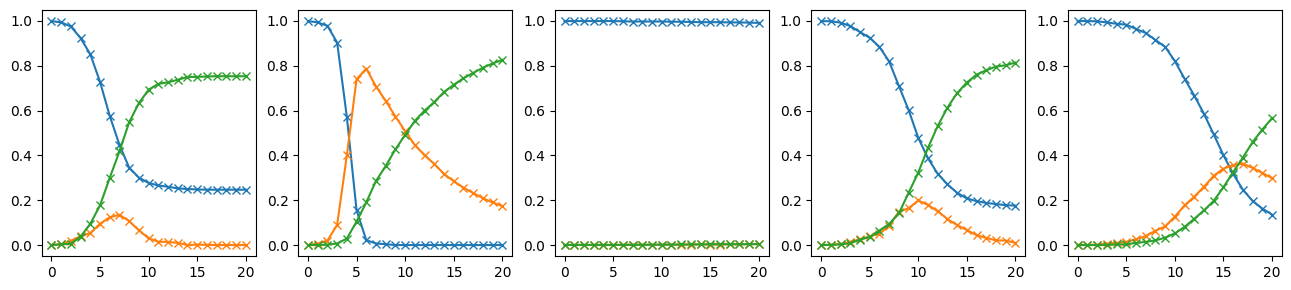

In [7]:
_, axes = plt.subplots(1, n_sets, figsize=(16, 16 / n_sets))

for data_set, ax in zip(data_sets, axes):
    ax.plot(data_set, 'x-')

## Set up and run pyABC problem

In [8]:
def model_abc(p):
    return {"y": simulate_sir_single(p["β"], p["γ"])}

gt_pars = [{"β": v[0], "γ": v[1]} for v in prior_samples]

par_limits = {
    "β": (low_beta, high_beta),
    "γ": (low_gamma, high_beta),
}

prior_abc = pyabc.Distribution(
    **{key: pyabc.RV("uniform", l, h-l)
       for key, (l, h) in par_limits.items()}
)

distance_abc = pyabc.PNormDistance(p=2)

In [9]:
pop_size = 1000

hs = []

for data_set in data_sets:
    abc = pyabc.ABCSMC(model_abc, prior_abc, distance_abc, population_size=pop_size)
    abc.new(pyabc.create_sqlite_db_id(), observed_sum_stat={"y": data_set})
    h = abc.run(max_nr_populations=10)
    hs.append(h)

ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=10, start_time=2022-12-20 19:19:21>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 3.55854152e+00.
ABC INFO: Accepted: 1000 / 1949 = 5.1308e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.86144454e+00.
ABC INFO: Accepted: 1000 / 2019 = 4.9529e-01, ESS: 9.6332e+02.
ABC INFO: t: 2, eps: 1.27456395e+00.
ABC INFO: Accepted: 1000 / 2107 = 4.7461e-01, ESS: 9.3677e+02.
ABC INFO: t: 3, eps: 8.87476298e-01.
ABC INFO: Accepted: 1000 / 2506 = 3.9904e-01, ESS: 9.0146e+02.
ABC INFO: t: 4, eps: 6.15305121e-01.
ABC INFO: Accepted: 1000 / 3033 = 3.2971e-01, ESS: 9.0580e+02.
ABC INFO: t: 5, eps: 4.29446980e-01.
ABC INFO: Accepted: 1000 / 4199 = 2.3815e-01, ESS: 8.4389e+02.
ABC INFO: t: 6, eps: 3.11363972e-01.
ABC INFO: Accepted: 1000 / 6222 = 1.6072e-01, ESS: 8.0804e+02.
ABC INFO: t: 7, eps: 2.31596111e-01.
ABC INFO: Accepted: 1000 / 9438 = 1.0595e-01, ESS: 7.4360e+02.
ABC INFO: t: 8, eps: 1.81486956e-01.


## Visualize results

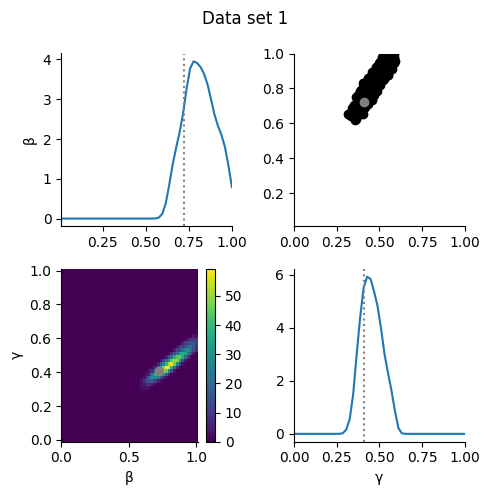

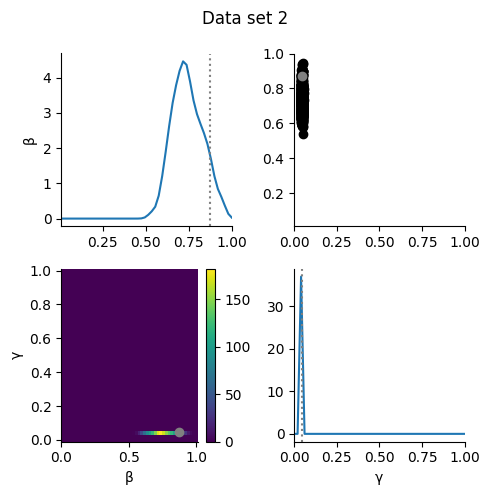

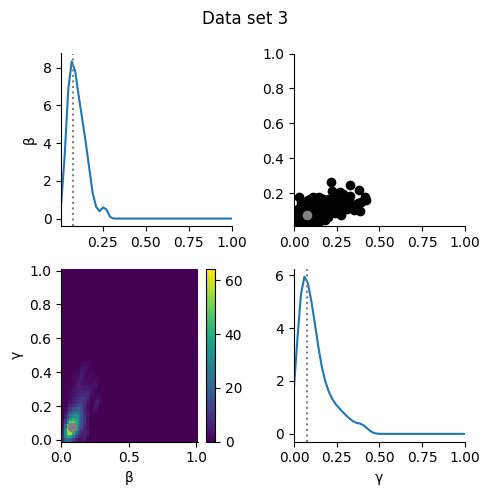

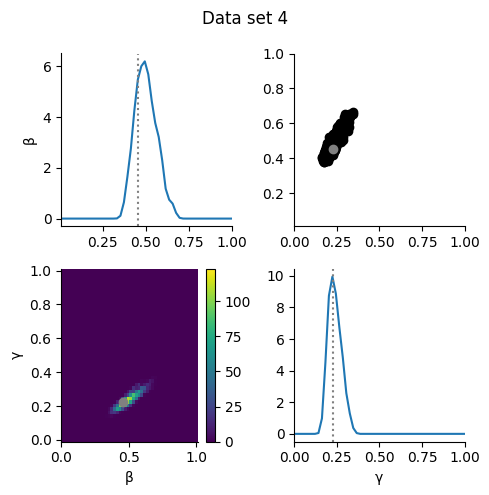

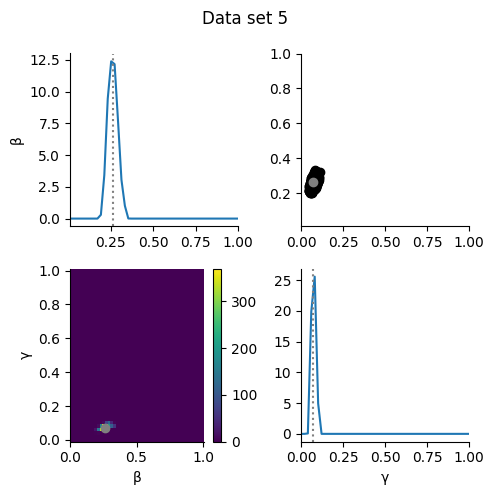

In [13]:
for ix, (gt_par, h) in enumerate(zip(gt_pars, hs)):
    pyabc.visualization.plot_kde_matrix_highlevel(
        h,
        limits=par_limits,
        refval=gt_par,
        refval_color="grey",
    )
    plt.gcf().suptitle(f"Data set {ix+1}")
    plt.gcf().tight_layout();

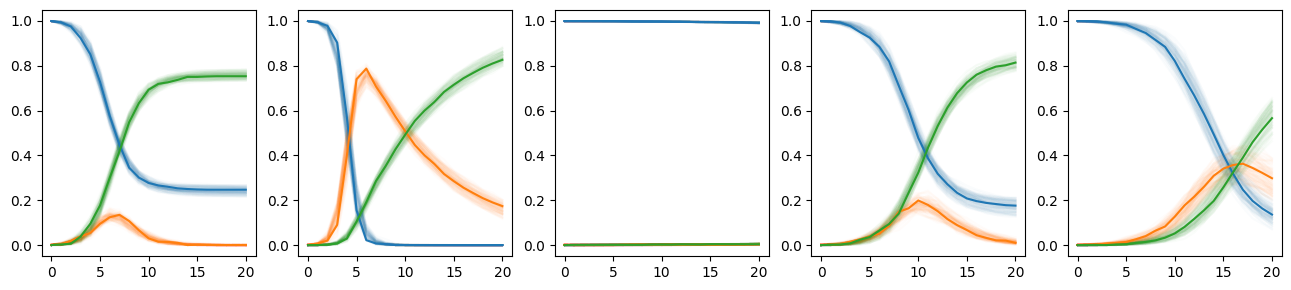

In [23]:
def plot_data(sumstat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    for i in range(3):
        ax.plot(sumstat["y"][:, i], color=f"C{i}", alpha=0.02)


_, axes = plt.subplots(1, n_sets, figsize=(16, 16 / n_sets))

for data_set, h, ax in zip(data_sets, hs, axes):
    pyabc.visualization.plot_data_callback(
        h,
        plot_data,
        ax=ax,
        n_sample=100,
    )
    ax.plot(data_set)